In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('/content/merged_hourly_load_weather.csv')

In [3]:

df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)


In [4]:

df.head()

,load,temperature_2m,relative_humidity_2m,precipitation,windspeed_10m,winddirection_10m,cloudcover,pressure_msl,dew_point_2m
datetime,,,,,,,,,
2018-01-01 00:00:00,1742.110000,11.8,76,0.0,3.7,281,0,1014.5,7.7
2018-01-01 01:00:00,1568.937500,9.0,86,0.0,4.8,257,0,1014.5,6.8
2018-01-01 02:00:00,1468.707500,8.1,87,0.0,6.5,264,0,1013.8,6.1
2018-01-01 03:00:00,1424.403333,7.9,87,0.0,7.9,267,0,1013.4,5.9
2018-01-01 04:00:00,1471.805000,8.1,85,0.0,6.1,273,0,1013.3,5.8


In [5]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df["day_of_month"] = df.index.day
df["day_of_year"] = df.index.day_of_year
df["year"] = df.index.year
df["week_of_year"] = df.index.isocalendar().week.astype("int64")
df.head()

,load,temperature_2m,relative_humidity_2m,precipitation,windspeed_10m,winddirection_10m,cloudcover,pressure_msl,dew_point_2m,hour,dayofweek,month,day_of_month,day_of_year,year,week_of_year
datetime,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1742.110000,11.8,76,0.0,3.7,281,0,1014.5,7.7,0,0,1,1,1,2018,1
2018-01-01 01:00:00,1568.937500,9.0,86,0.0,4.8,257,0,1014.5,6.8,1,0,1,1,1,2018,1
2018-01-01 02:00:00,1468.707500,8.1,87,0.0,6.5,264,0,1013.8,6.1,2,0,1,1,1,2018,1
2018-01-01 03:00:00,1424.403333,7.9,87,0.0,7.9,267,0,1013.4,5.9,3,0,1,1,1,2018,1
2018-01-01 04:00:00,1471.805000,8.1,85,0.0,6.1,273,0,1013.3,5.8,4,0,1,1,1,2018,1


In [6]:
!pip install tensorflow

In [7]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
threshold_date_1 = "01-01-2024"
threshold_date_2 = "01-01-2025"

In [9]:
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

In [10]:
FEATURES = ["hour", "day_of_month", "dayofweek", "day_of_year", "month", "year", "week_of_year", "temperature_2m", "relative_humidity_2m",	"windspeed_10m", "dew_point_2m"]
TARGET = "load"
FEATURES_TARGET = FEATURES.copy()
FEATURES_TARGET.append(TARGET)
train_data_keras = train_data[FEATURES_TARGET]
test_data_keras = test_data[FEATURES_TARGET]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_keras_s = scaler.fit_transform(train_data_keras.values)
test_data_keras_s = scaler.transform(test_data_keras.values)

X_train_keras = train_data_keras_s[:, :-1].reshape(train_data_keras_s.shape[0], 1, len(FEATURES))
y_train_keras = train_data_keras_s[:, -1]
X_test_keras = test_data_keras_s[:, :-1].reshape(test_data_keras_s.shape[0], 1, len(FEATURES))
y_test_keras = test_data_keras_s[:, -1]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 11)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 64)          │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 1, 64)          │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,033 (328.25 KB)

 Trainable params: 84,033 (328.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.5489 - val_loss: 0.1240 - learning_rate: 0.0010
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1383 - val_loss: 0.1187 - learning_rate: 0.0010
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1176 - val_loss: 0.1029 - learning_rate: 0.0010
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1044 - val_loss: 0.0958 - learning_rate: 0.0010
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0975 - val_loss: 0.0860 - learning_rate: 0.0010
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0900 - val_loss: 0.0853 - learning_rate: 0.0010
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0838 - val_loss: 0.0838 - learning_rate: 0.0010
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0758 - val_loss: 0.0819 - learning_rate: 0.0010
Epoch 9/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0706 - val_loss: 0.0652 - learning_rate: 0.0010

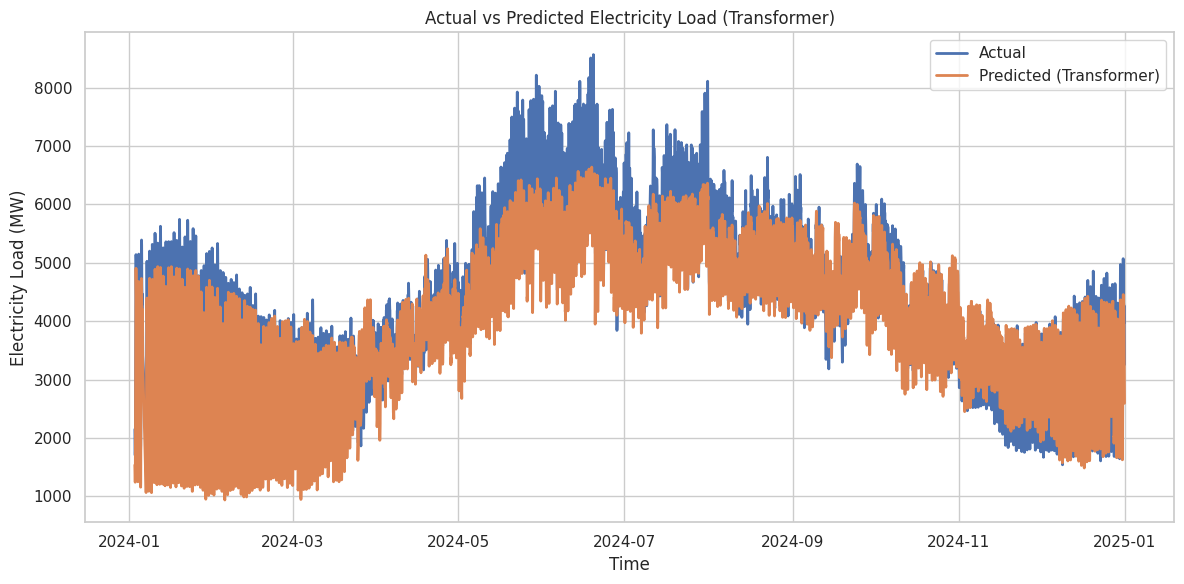

In [11]:
# Transformer-based model version

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    GlobalAveragePooling1D, Flatten
)
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Transformer block definition
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(d_model)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        # Self-attention
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        # Feed-forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# ---- Model hyperparameters ----
d_model = 64
num_heads = 4
ff_dim = 128
dropout_rate = 0.5
num_transformer_blocks = 1
seq_len = X_train_keras.shape[1]
n_features = X_train_keras.shape[2]

# Build the Transformer model (Functional API)
inputs = Input(shape=(seq_len, n_features))
# Project features to d_model dimensions
x = Dense(d_model)(inputs)

# Add transformer blocks
for _ in range(num_transformer_blocks):
    x = TransformerBlock(d_model=d_model, num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)(x)

# Pool across sequence dimension
x = GlobalAveragePooling1D()(x)
x = Dropout(dropout_rate)(x)
# Final regression head
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mae")
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=8, mode='min')
model_checkpoint = ModelCheckpoint('delhitransformer_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=0,
    mode='min'
)

# Train
model.fit(
    X_train_keras, y_train_keras,
    epochs=100,
    batch_size=144,
    validation_data=(X_test_keras, y_test_keras),
    callbacks=[early_stopping, model_checkpoint, reduce_lr_loss]
)

# Evaluation
pred_trans = model.predict(X_test_keras)
results_trans = test_data_keras_s.copy()
results_trans[:, -1] = pred_trans.reshape(-1)
results_trans = scaler.inverse_transform(results_trans)
result_frame_trans = pd.DataFrame(index=test_data.index)
result_frame_trans["load"] = test_data["load"]
result_frame_trans["pred_trans"] = results_trans[:, -1]
mape_trans = np.mean(np.abs((result_frame_trans["load"] - result_frame_trans["pred_trans"]) / result_frame_trans["load"])) * 100
rmse_trans = np.sqrt(np.mean(np.square(result_frame_trans["load"] - result_frame_trans["pred_trans"])))

print(f"MAPE of Transformer Model: {mape_trans:.2f}%")
print(f"RMSE of Transformer Model: {rmse_trans:.2f} MW")

# Plot
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
rcParams['figure.figsize'] = 12, 6

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(result_frame_trans.index, result_frame_trans['load'], label='Actual', linewidth=2)
ax.plot(result_frame_trans.index, result_frame_trans['pred_trans'], label='Predicted (Transformer)', linewidth=2)
ax.set_xlabel("Time")
ax.set_ylabel("Electricity Load (MW)")
ax.set_title("Actual vs Predicted Electricity Load (Transformer)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


X_train_seq.shape, y_train_seq.shape: (50488, 24, 11) (50488,)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 24, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24, 128)        │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, 24, 128)        │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 24, 128)        │       330,240 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 24, 128)        │       330,240 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 662,145 (2.53 MB)

 Trainable params: 662,145 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
789/789 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - loss: 0.3585 - val_loss: 0.0787 - learning_rate: 0.0010
Epoch 2/80
789/789 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0624 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 3/80
789/789 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0509 - val_loss: 0.0543 - learning_rate: 0.0010
Epoch 4/80
789/789 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0448 - val_loss: 0.0492 - learning_rate: 0.0010
Epoch 5/80
789/789 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0401 - val_loss: 0.0484 - learning_rate: 0.0010
Epoch 6/80
789/789 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0379 - val_loss: 0.0466 - learning_rate: 0.0010
Epoch 7/80
789/789 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0380 - val_loss: 0.0568 - learning_rate: 0.0010
Epoch 8/80
789/789 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0355 - val_loss: 0.0491 - learning_rate: 0.0010
Epoch 9/80
789/789 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0339 - val_loss: 0.0618 - learning_rate: 0.0010
Epoch 10

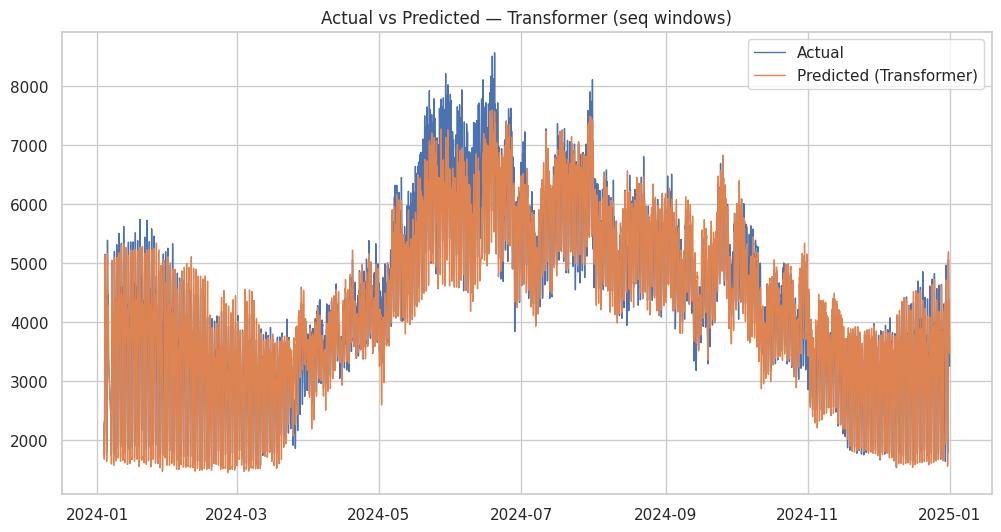

In [12]:
#Sliding windows + Transformer with positional encoding
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Sequential

# 1) Scale BEFORE creating windows
# scaler = MinMaxScaler(...)
# train_data_keras_s = scaler.fit_transform(train_data_keras.values)
# test_data_keras_s  = scaler.transform(test_data_keras.values)

#create sliding windows from scaled numpy array
def create_sequences(data_scaled, seq_len=24):
    """
    data_scaled: numpy array shape (n_samples, n_features+1_target)
    returns:
      X: shape (n_windows, seq_len, n_features)
      y: shape (n_windows,)
    """
    X_list, y_list = [], []
    n_total = data_scaled.shape[0]
    n_feats = data_scaled.shape[1] - 1
    for i in range(seq_len, n_total):
        seq = data_scaled[i-seq_len:i, :-1]
        target = data_scaled[i, -1]
        X_list.append(seq)
        y_list.append(target)
    return np.array(X_list), np.array(y_list)
SEQ_LEN = 24

# create sequences for train and test
X_train_seq, y_train_seq = create_sequences(train_data_keras_s, seq_len=SEQ_LEN)
X_test_seq, y_test_seq   = create_sequences(test_data_keras_s, seq_len=SEQ_LEN)

print("X_train_seq.shape, y_train_seq.shape:", X_train_seq.shape, y_train_seq.shape)

# 2) Positional encoding layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model
        # precompute positional enc
        pos = np.arange(seq_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        angle_rads = pos * angle_rates
        pe = np.zeros((seq_len, d_model))
        pe[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pe[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pe = tf.cast(pe[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pe


# 3) TransformerBlock
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout_rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = Sequential([Dense(ff_dim, activation="relu"), Dense(d_model)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# 4) Build model
d_model = 128
num_heads = 4
ff_dim = 256
dropout_rate = 0.2
num_blocks = 2

seq_len = SEQ_LEN
n_features = X_train_seq.shape[2]

inputs = Input(shape=(seq_len, n_features))
# feature projection -> d_model
x = Dense(d_model)(inputs)
# add positional encoding
x = PositionalEncoding(seq_len=seq_len, d_model=d_model)(x)

for _ in range(num_blocks):
    x = TransformerBlock(d_model=d_model, num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)(x)

# global pooling and regression head
x = GlobalAveragePooling1D()(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mae')
model.summary()

# 5) Callbacks & training
early_stopping = EarlyStopping(monitor='val_loss', patience=12, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('delhitrans_seq_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, mode='min')

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=80,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


# 6) Predict and inverse-transform predictions
pred_scaled = model.predict(X_test_seq).reshape(-1)
n_test_windows = X_test_seq.shape[0]
results_pred_full = np.zeros((n_test_windows, test_data_keras.shape[1]))
for i in range(n_test_windows):
    last_feats = X_test_seq[i, -1, :].copy()
    combined = np.concatenate([last_feats, pred_scaled[i:i+1]])
    results_pred_full[i, :] = combined

# inverse transform
results_pred_inv = scaler.inverse_transform(results_pred_full)
preds_original_scale = results_pred_inv[:, -1]

# Construct index alignment for plotting: predictions correspond to test_data index starting at position seq_len
test_index_for_preds = test_data.index[SEQ_LEN:]

import pandas as pd
result_frame = pd.DataFrame(index=test_index_for_preds)
result_frame['actual_load'] = test_data['load'].iloc[SEQ_LEN:].values
result_frame['pred_trans'] = preds_original_scale

# Safe MAPE calculation - avoid division by zero
eps = 1e-6
mape_trans = np.mean(np.abs((result_frame['actual_load'] - result_frame['pred_trans']) / (result_frame['actual_load'] + eps))) * 100
rmse_trans = np.sqrt(np.mean((result_frame['actual_load'] - result_frame['pred_trans'])**2))

print(f"MAPE (Transformer seq_len={SEQ_LEN}): {mape_trans:.2f}%")
print(f"RMSE: {rmse_trans:.2f}")

# Plot
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(style="whitegrid")
rcParams['figure.figsize'] = 12, 6

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(result_frame.index, result_frame['actual_load'], label='Actual', linewidth=1)
ax.plot(result_frame.index, result_frame['pred_trans'], label='Predicted (Transformer)', linewidth=1)
ax.legend(); ax.set_title("Actual vs Predicted — Transformer (seq windows)")
plt.show()
